Today I'll be running through Stochastic Volatility Models! These are related to GARCH models in that they allow for time-varying volatility in the return distribution. In other words, it accounts for heteroscedasticity.

# Data

I'm interested in the weekly returns of the S&P 500 index. My intent is to trade weekly options to go short volatility, so weekly forecasts are what I need.

In [78]:
import numpy as np
import pandas as pd
from cmdstanpy import cmdstan_path, CmdStanModel
import matplotlib.pyplot as plt
import arviz as az
from scipy import stats
import statsmodels.api as sm

from datamodel import SPX, StockData

plt.rcParams["figure.figsize"] = (15,10)

In [2]:
spx = SPX()

In [5]:
spx_wk_prices = spx.prices.resample("W-FRI").last()
spx_wk_returns = (np.log(spx_wk_prices) - np.log(spx_wk_prices.shift(1))).dropna()

Here are what the weekly returns look like for the past 20-ish years. You can see that volatility "clusters" meaning that periods of extreme returns are generally followed by periods of extreme returns.

<AxesSubplot:title={'center':'S&P 500 Index Weekly Returns'}, xlabel='Date', ylabel='Return'>

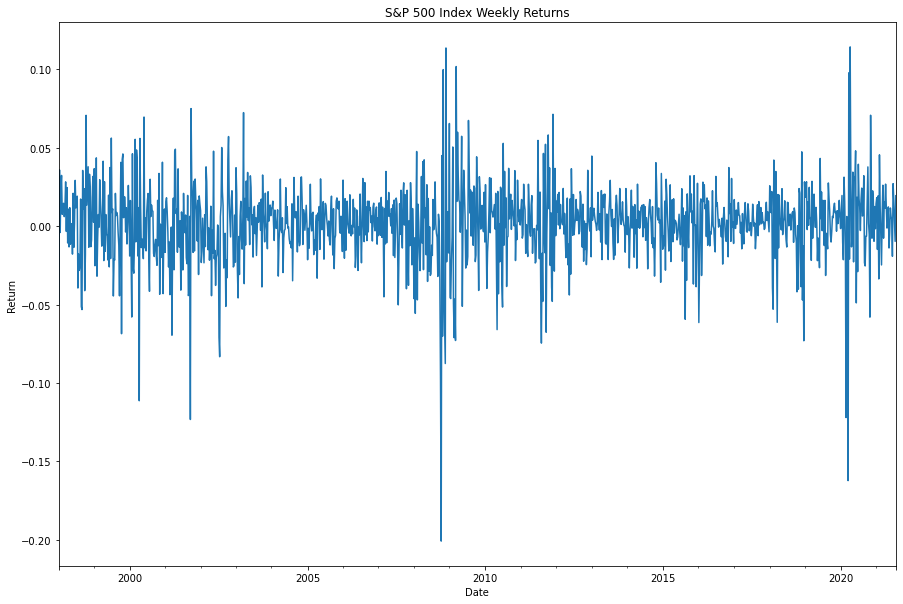

In [157]:
spx_wk_returns.plot(title="S&P 500 Index Weekly Returns", xlabel="Date", ylabel="Return")

This can be more easily seen with autocorrelation plots. Let's look at the returns themselves first:

Text(0, 0.5, 'Correlation')

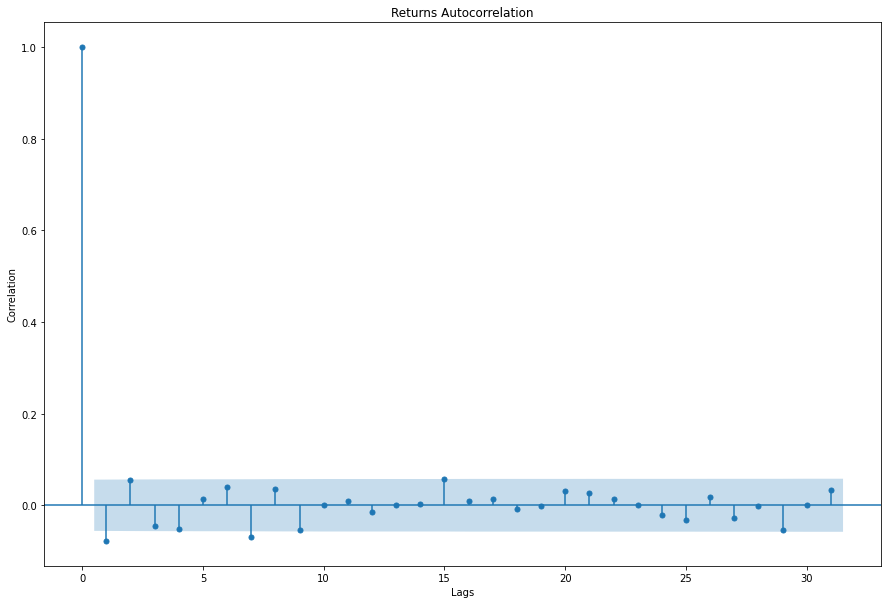

In [170]:
fig = sm.tsa.graphics.plot_acf(spx_wk_returns, title="Returns Autocorrelation")
plt.xlabel("Lags")
plt.ylabel("Correlation")

There's very little autocorrelation, meaning that returns at each time period are unrelated to the returns that came at past time periods. However, let's look at the square of returns, which is a crude way to estimate their volatility.

Text(0, 0.5, 'Correlation')

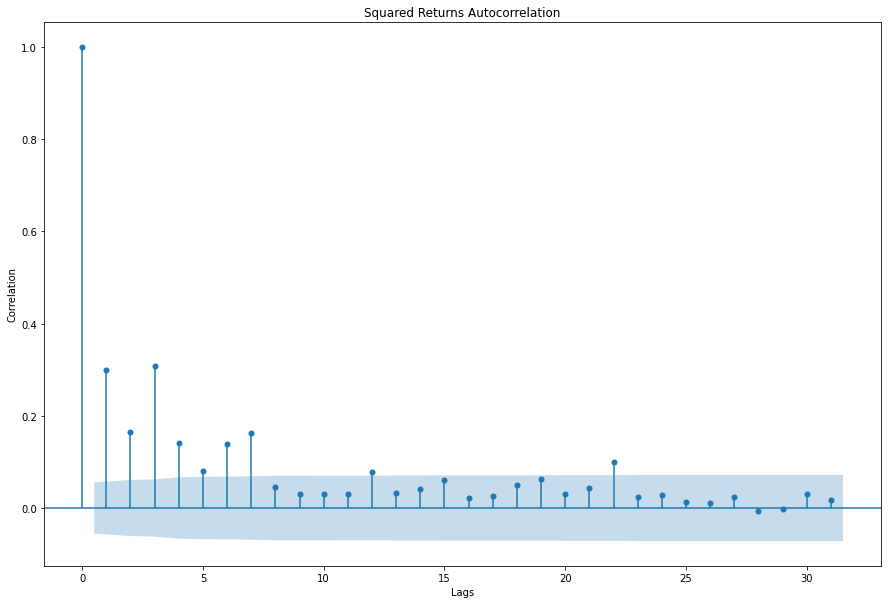

In [169]:
fig = sm.tsa.graphics.plot_acf(spx_wk_returns**2, title="Squared Returns Autocorrelation")
plt.xlabel("Lags")
plt.ylabel("Correlation")

Now there is clearly some significant autocorrelation, meaning volatility is affected by past volatility, thus the clustering effect. When there is a volatility shock, we expect to see periods of lasting higher volatility.

# The Model

I'm going to be fitting a Stochastic Volatility Model which differs from a standard GARCH model. In a GARCH model, variance is modeled as a deterministic function of past errors and past variances:

$$ \sigma_{t}^2 = \omega + \alpha_{1} \epsilon_{t-1}^2 + \beta_{1} \sigma_{t-1}^2 $$

However, in a Stochastic Volatility Model, variance is modeled as a *stochastic* function of past variance:

$$ \sigma_{t}^2 = \mu + \phi (\sigma_{t-1}^2 - \mu) + \epsilon_{t}$$

$$ \epsilon_{t} \sim \mathcal{N}(0,\, \omega) $$

This model is what is encapsulated below in Stan model language. To use the symbols below it's like this:

$$ r_{t} \sim \mathcal{N}(\mu_{r}, \exp({h_{t} / 2})) $$

$$ h_{t} = \mu_{h} + \phi (h_{t-1} - \mu_{h}) + \epsilon_{t}$$

$$ \epsilon_{t} \sim \mathcal{N}(0, \sigma) $$

Note here that $h$ represents the logarithm of variance. This makes its distribution far more symmterical than in its normal form, making fitting the model easier. The gist of the model is that there exists a normal mean variance level represented by $\mu_{h}$ and when shocks occur, whose magnitude is governed by $\sigma$, variance will tend back towards that mean at a rate dictated by $\phi$.

I generate the posterior predictive distribution in the generated quantities block, this will be useful for analysis of the model. I'm using broad uniformative priors here because I have plenty enough data points that they hardly matter.

In [171]:
model_spec = """
    data {
        int N;                              // Length of data
        vector[N] r;                        // SPX returns
    }
    parameters {
        real mu_h;                          // Volatility mean term
        real mu_r;                          // Returns mean term
        real<lower=-1, upper=1> phi;        // Persistence of volatility
        real<lower=0> sigma;                // Volatility noise
        vector[N] h_std;                    // Log volatility
    }
    transformed parameters {
        vector[N] h = h_std * sigma;        // h ~ normal(0, sigma);
        h[1] /= sqrt(1 - square(phi));      // h[1] ~ normal(0, sigma / sqrt(1 - square(phi)))
        h += mu_h;                          // h ~ normal(mu_h, sigma)
        for (t in 2:N) {
            h[t] += phi * (h[t-1] - mu_h);  // h[2:N] ~ normal(mu_h + phi * (h[t-1] - mu_h), sigma)
        }
    }
    model {
        phi ~ uniform(-1, 1);
        sigma ~ normal(0, 10);
        mu_h ~ normal(0, 10);
        mu_r ~ normal(0, 10);
        
        h_std ~ std_normal();
        r ~ normal(mu_r, exp(h / 2));
    }
    generated quantities {
        real r_tilde[N];
        r_tilde = normal_rng(mu_r, exp(h / 2));
    }
"""
with open("./stan_model/model.stan", "w") as file:
    file.write(model_spec)

model = CmdStanModel(stan_file="./stan_model/model.stan")

INFO:cmdstanpy:compiling stan program, exe file: /home/eadains/VolatilityTrading/stan_model/model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/eadains/VolatilityTrading/stan_model/model


In [172]:
data = {"N": len(spx_wk_returns), "r": spx_wk_returns.values}
sample = model.sample(data=data,
                      chains=4,
                      parallel_chains=4,
                      output_dir="./stan_model",
                      iter_warmup=1000,
                      iter_sampling=2500)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1


In [173]:
arviz_data = az.from_cmdstanpy(posterior=sample,
                               posterior_predictive="r_tilde",
                               observed_data={"r": spx_wk_returns.values})

First let's look at how our chain sampled to make sure everything looks okay.

array([[<AxesSubplot:title={'center':'mu_h'}>,
        <AxesSubplot:title={'center':'mu_h'}>],
       [<AxesSubplot:title={'center':'mu_r'}>,
        <AxesSubplot:title={'center':'mu_r'}>],
       [<AxesSubplot:title={'center':'phi'}>,
        <AxesSubplot:title={'center':'phi'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

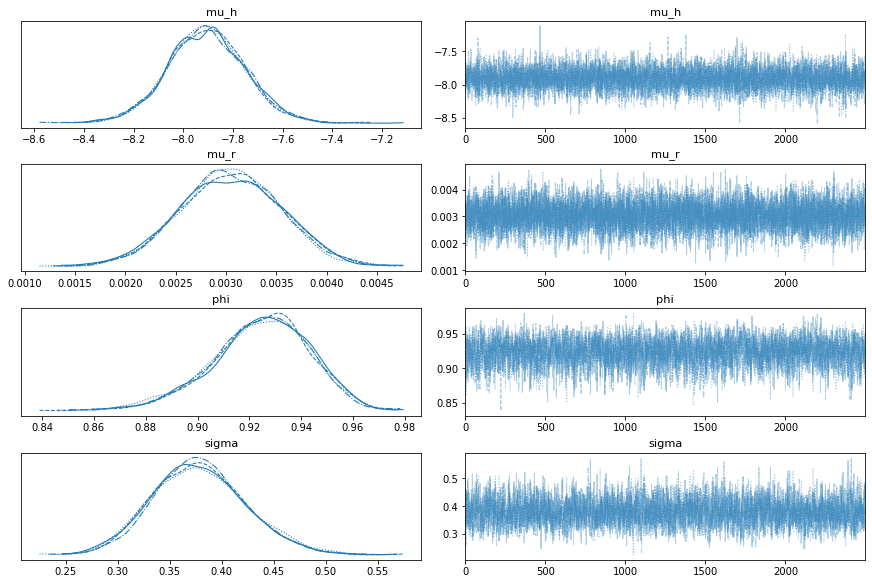

In [176]:
az.plot_trace(arviz_data, compact=True, var_names=["mu_h", "mu_r", "phi", "sigma"])

Okay there is no obvious issues here. The parameter distributions from each chain look mostly the same, and there aren't any obvious signs of autocorrelation in the samples. Next, let's look at the summary statistics from our posterior predictive distribution versus our data. The blue histogram bars represent the posterior predictive, and the black line represents that statistic calculated from the data.

In [177]:
r_tilde = arviz_data.posterior_predictive.r_tilde.values.reshape(10000, -1)
vol = arviz_data.posterior.h.values.reshape(10000, -1)
mean = np.mean(r_tilde, axis=1)
std = np.std(r_tilde, axis=1)
skew = stats.skew(r_tilde, axis=1)
kurt = stats.kurtosis(r_tilde, axis=1)

Text(0.5, 1.0, 'Kurtosis')

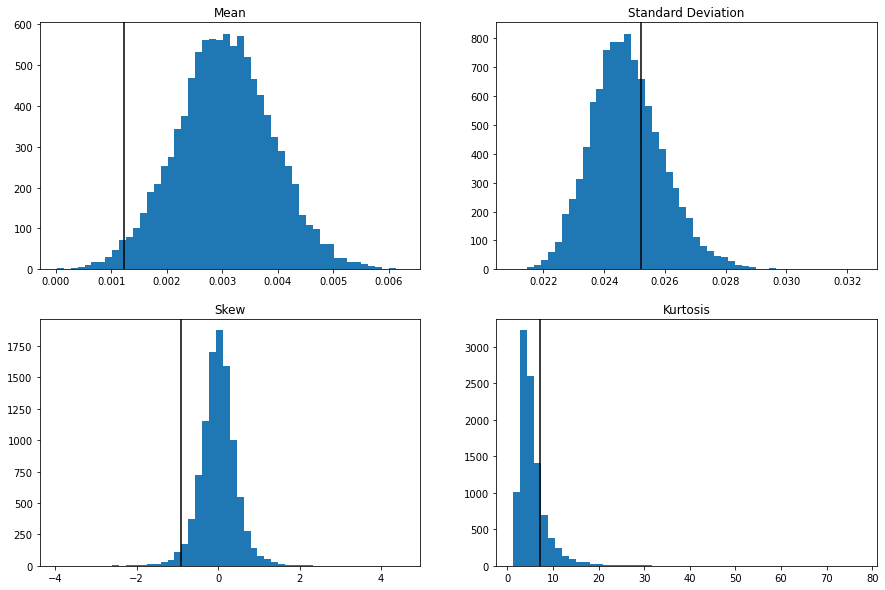

In [179]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(mean, bins=50)
axs[0, 0].axvline(np.mean(spx_wk_returns), color='black')
axs[0, 0].set_title("Mean")
axs[0, 1].hist(std, bins=50)
axs[0, 1].axvline(np.std(spx_wk_returns), color='black')
axs[0, 1].set_title("Standard Deviation")
axs[1, 0].hist(skew, bins=50)
axs[1, 0].axvline(stats.skew(spx_wk_returns), color='black')
axs[1, 0].set_title("Skew")
axs[1, 1].hist(kurt, bins=50)
axs[1, 1].axvline(stats.kurtosis(spx_wk_returns), color='black')
axs[1, 1].set_title("Kurtosis")

There are some issues here, right off the bat. Ideally, the black line should fall in a high probability region of the histogram. This would mean that the data simulated from our model closely matches the qualities of the input data. This looks true mostly only for the standard deviation and kurtosis. It seems like the model is not modeling the mean or skew very well. Next let's look at the distribution of our input data versus the distribution of the posterior predictive.

<AxesSubplot:xlabel='r / r_tilde'>

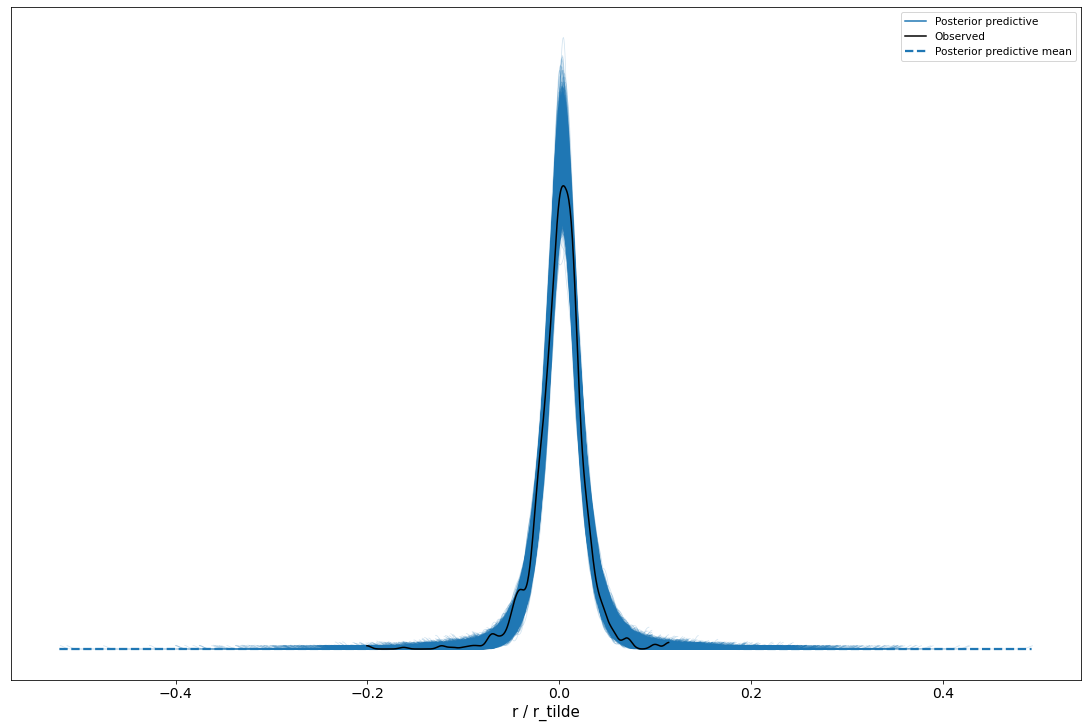

In [180]:
az.plot_ppc(arviz_data, data_pairs={"r": "r_tilde"})

This looks pretty good! The distributions look mostly the same. Next, I want to look at how well calibrated the model is. The model outputs a distributional estimate at each time point. So ideally, for instance, if we calculate the 95th percentile of that distribution, the input data should have values higher than that only 5% of the time. Likewise that data should have values smaller than the 5% percentile only 5% of the time.

In [181]:
# 95% bounds exceedences
np.sum(spx_wk_returns.values > np.percentile(r_tilde, 95, axis=0)) / len(spx_wk_returns)

0.01627339300244101

In [182]:
# 5% bounds exceedences
np.sum(spx_wk_returns.values < np.percentile(r_tilde, 5, axis=0)) / len(spx_wk_returns)

0.03824247355573637

So 1.6% of the time the data values are above the 95% bounds, and 3.8% of the time the data values are below the 5% bounds. If anything then, our distribution may be too broad. However, in this case that could be considered a good thing because I'd rather predict a broader distribution of returns than a too restrictive one. It's best to be over-prepared for extreme outcomes than under-prepared. The next plot is the 95% and 5% bounds plotted against the return data. You can see the points where the returns exceed those bounds.

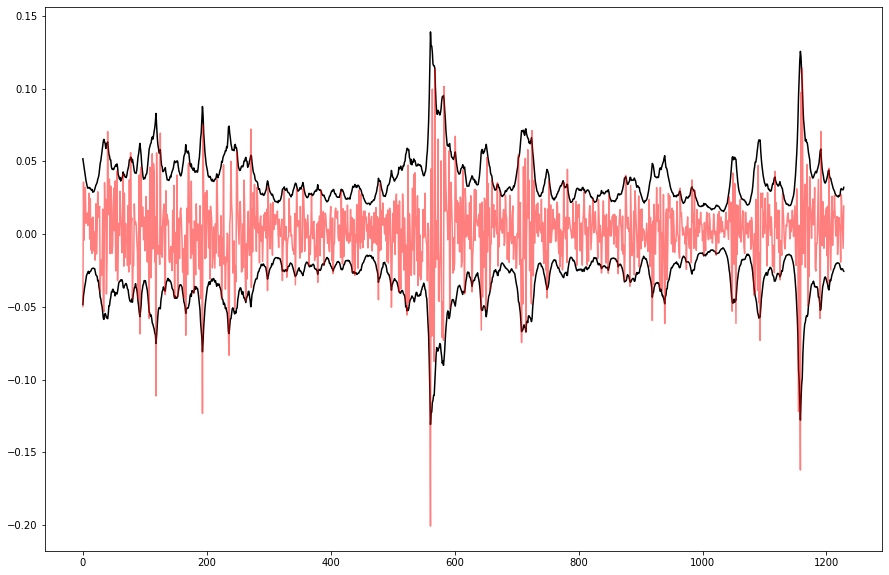

In [189]:
plt.plot(np.percentile(r_tilde, 95, axis=0), color="black")
plt.plot(np.percentile(r_tilde, 5, axis=0), color="black")
plt.plot(spx_wk_returns.values, color="red", alpha=0.5)

The next test is doing a probability integral transform. When you put a value through a CDF it gets transformed onto the range 0 to 1. Ideally, if I put the data through the CDF implied by the model, those output values should be uniformally distributed. This implies that the predicted distribution accurately predicts the probabilities of events. Unlike the exceedences test, which only looks at the tails, this test looks at the entire distribution.

In [190]:
values = []

for t in range(len(spx_wk_returns)):
    ecdf = sm.distributions.empirical_distribution.ECDF(r_tilde[:, t])
    values.append(ecdf(spx_wk_returns.iloc[t]))

In [191]:
stats.kstest(values, "uniform")

KstestResult(statistic=0.03910358014646054, pvalue=0.04540901853352719)

This does the Kolmogorov–Smirnov test, which determines if the distribution of some values matches some reference distribution. The null hypothesis is that the values come from the prescribed distribution. So with a p-value of 0.05 we can reject that null hypothesis in this case.

/home/eadains/VolatilityTrading/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


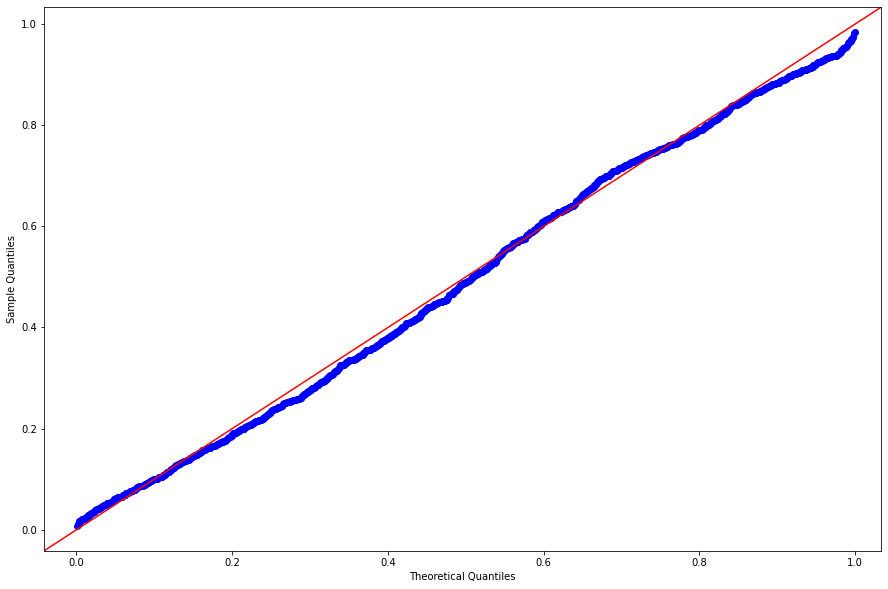

In [192]:
fig = sm.graphics.qqplot(np.array(values), dist=stats.uniform, line="45")

A QQ plot is another way of doing that analysis visually. If the samples match a uniform distribution, they should all fall perfectly on the 45 degree line in the figure. It's clear there is some odd behaviour at the right tail and in the center. It seems like our distributional esimate doesn't match the data too well.

# Model Improvement

Okay, so issues are that the mean and skew seem off, and the distribution estimate doesn't match too well with the data. What should I try? Well, we expect negative skew, because large negative returns happen rarely. So instead of assuming a normal error for returns, let's try a skew normal! So everything is the same but the sampling statement for the returns looks like this now:

$$ r_{t} \sim Skew Normal(\mu_{r}, \exp(h_{t} / 2), \alpha) $$

Where $\alpha$ is a new parameter that dictates the level of skew. In Stan, that model looks like this.

In [198]:
model_spec = """
    data {
        int N;                              // Length of data
        vector[N] r;                        // SPX returns
    }
    parameters {
        real mu_h;                          // Volatility mean term
        real mu_r;                          // Returns mean term
        real<lower=-1, upper=1> phi;        // Persistence of volatility
        real<lower=0> sigma;                // Volatility noise
        vector[N] h_std;                    // Log volatility
        real alpha;                         // Skew Normal shape parameter
    }
    transformed parameters {
        vector[N] h = h_std * sigma;        // h ~ normal(0, sigma);
        h[1] /= sqrt(1 - square(phi));      // h[1] ~ normal(0, sigma / sqrt(1 - square(phi)))
        h += mu_h;                          // h ~ normal(mu_h, sigma)
        for (t in 2:N) {
            h[t] += phi * (h[t-1] - mu_h);  // h[2:N] ~ normal(mu_h + phi * (h[t-1] - mu_h), sigma)
        }
    }
    model {
        phi ~ uniform(-1, 1);
        sigma ~ normal(0, 10);
        mu_h ~ normal(0, 10);
        mu_r ~ normal(0, 10);
        alpha ~ normal(0, 10);
        
        h_std ~ std_normal();
        r ~ skew_normal(mu_r, exp(h / 2), alpha);
    }
    generated quantities {
        real r_tilde[N];
        r_tilde = skew_normal_rng(mu_r, exp(h / 2), alpha);
    }
"""
with open("./stan_model/model.stan", "w") as file:
    file.write(model_spec)

model = CmdStanModel(stan_file="./stan_model/model.stan")

INFO:cmdstanpy:compiling stan program, exe file: /home/eadains/VolatilityTrading/stan_model/model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/eadains/VolatilityTrading/stan_model/model


In [199]:
data = {"N": len(spx_wk_returns), "r": spx_wk_returns.values}
sample = model.sample(data=data,
                      chains=4,
                      parallel_chains=4,
                      output_dir="./stan_model",
                      iter_warmup=1000,
                      iter_sampling=2500)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1


In [200]:
arviz_data = az.from_cmdstanpy(posterior=sample,
                               posterior_predictive="r_tilde",
                               observed_data={"r": spx_wk_returns.values})

array([[<AxesSubplot:title={'center':'mu_h'}>,
        <AxesSubplot:title={'center':'mu_h'}>],
       [<AxesSubplot:title={'center':'mu_r'}>,
        <AxesSubplot:title={'center':'mu_r'}>],
       [<AxesSubplot:title={'center':'phi'}>,
        <AxesSubplot:title={'center':'phi'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

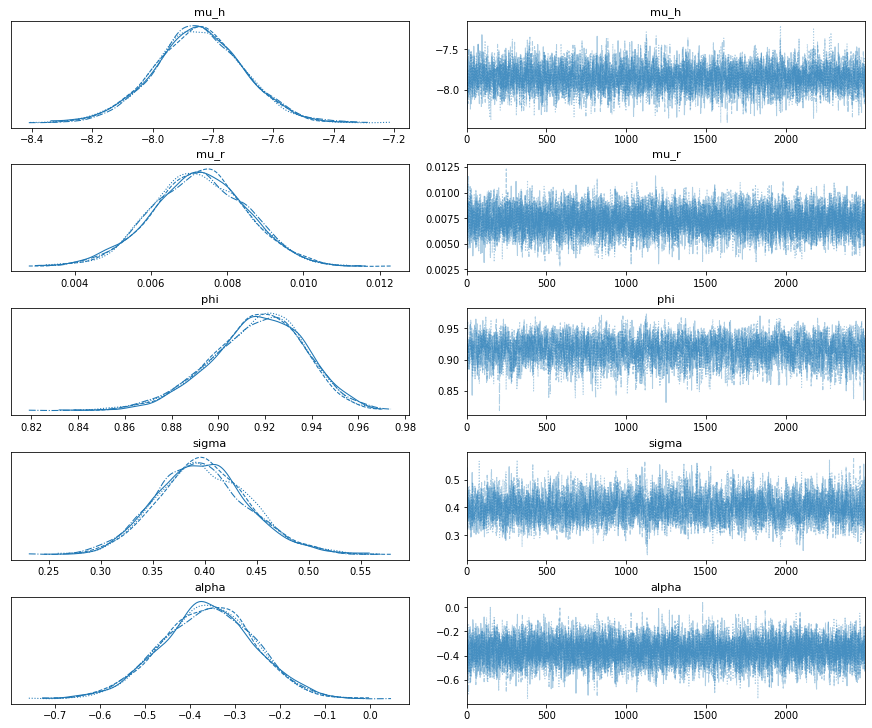

In [201]:
az.plot_trace(arviz_data, compact=True, var_names=["mu_h", "mu_r", "phi", "sigma", "alpha"])

Again, everything looks good here. Alpha centers around a negative value, which is a good sign, because negative skew was expected.

In [202]:
r_tilde = arviz_data.posterior_predictive.r_tilde.values.reshape(10000, -1)
vol = arviz_data.posterior.h.values.reshape(10000, -1)
mean = np.mean(r_tilde, axis=1)
std = np.std(r_tilde, axis=1)
skew = stats.skew(r_tilde, axis=1)
kurt = stats.kurtosis(r_tilde, axis=1)

Text(0.5, 1.0, 'Kurtosis')

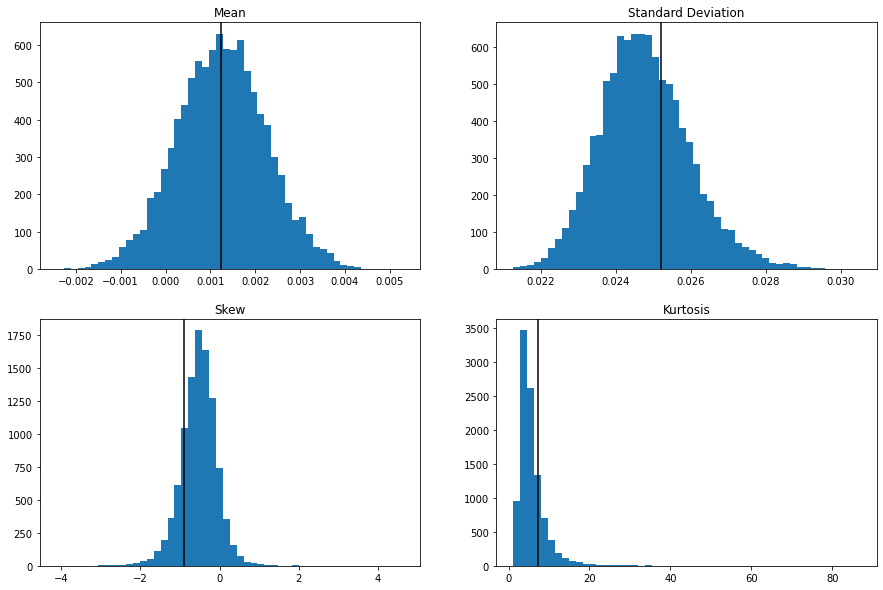

In [203]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(mean, bins=50)
axs[0, 0].axvline(np.mean(spx_wk_returns), color='black')
axs[0, 0].set_title("Mean")
axs[0, 1].hist(std, bins=50)
axs[0, 1].axvline(np.std(spx_wk_returns), color='black')
axs[0, 1].set_title("Standard Deviation")
axs[1, 0].hist(skew, bins=50)
axs[1, 0].axvline(stats.skew(spx_wk_returns), color='black')
axs[1, 0].set_title("Skew")
axs[1, 1].hist(kurt, bins=50)
axs[1, 1].axvline(stats.kurtosis(spx_wk_returns), color='black')
axs[1, 1].set_title("Kurtosis")

Now the mean value lies right in the center of the distribution and the skew value is closer to the middle then it was before. That looks like progress!

<AxesSubplot:xlabel='r / r_tilde'>

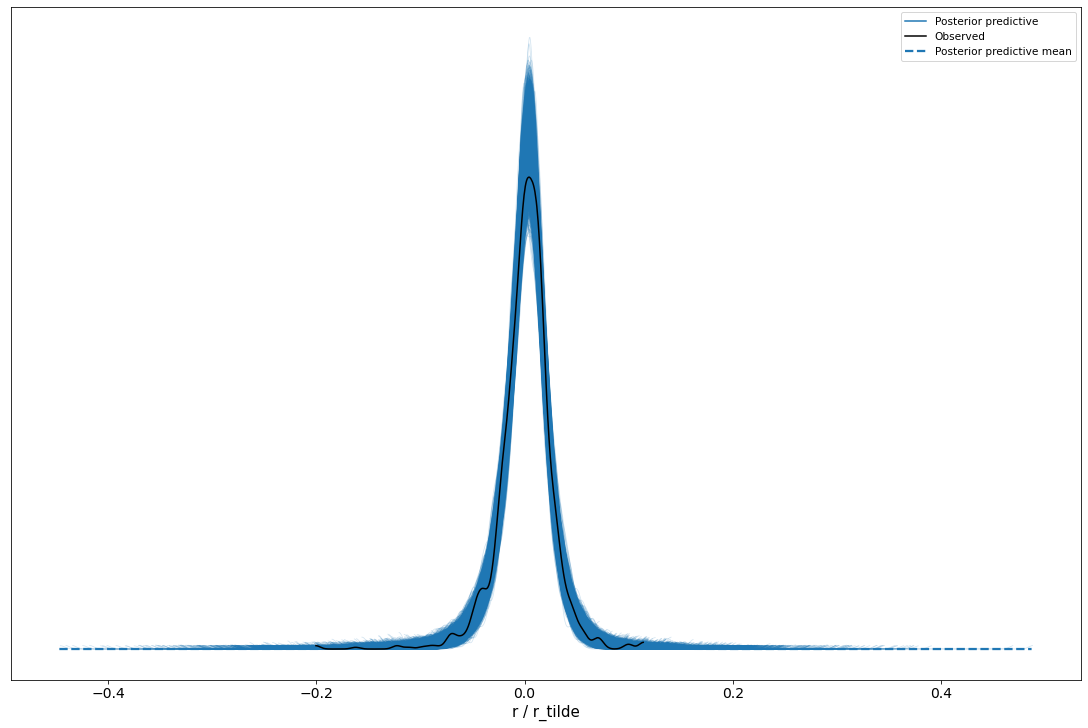

In [204]:
az.plot_ppc(arviz_data, data_pairs={"r": "r_tilde"})

In [205]:
# 95% bounds exceedences
np.sum(spx_wk_returns.values > np.percentile(r_tilde, 95, axis=0)) / len(spx_wk_returns)

0.024410089503661515

In [206]:
# 5% bounds exceedences
np.sum(spx_wk_returns.values < np.percentile(r_tilde, 5, axis=0)) / len(spx_wk_returns)

0.021969080553295363

Our exceedences are again a bit too broad but they are more even than the first model.

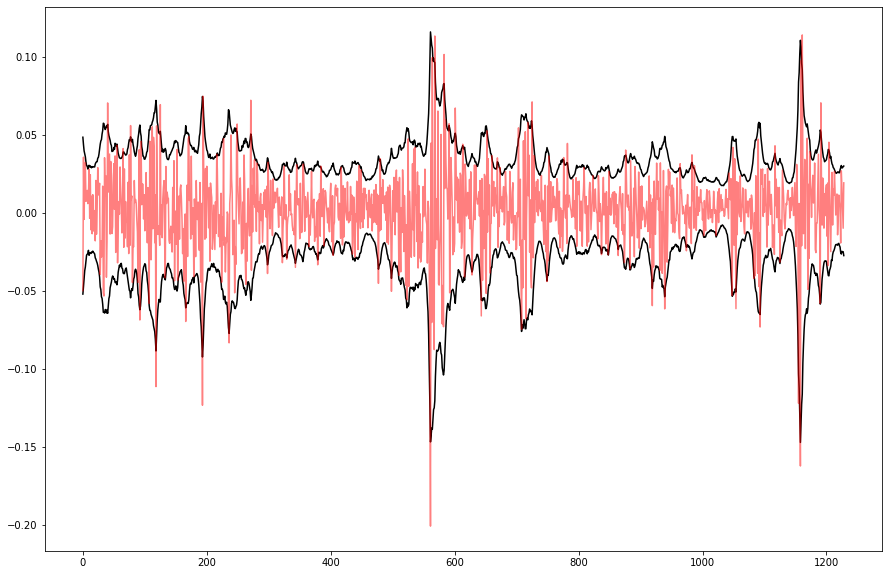

In [207]:
plt.plot(np.percentile(r_tilde, 95, axis=0), color="black")
plt.plot(np.percentile(r_tilde, 5, axis=0), color="black")
plt.plot(spx_wk_returns.values, color="red", alpha=0.5)

In [208]:
values = []

for t in range(len(spx_wk_returns)):
    ecdf = sm.distributions.empirical_distribution.ECDF(r_tilde[:, t])
    values.append(ecdf(spx_wk_returns.iloc[t]))

In [209]:
stats.kstest(values, "uniform")

KstestResult(statistic=0.030034499593165176, pvalue=0.21322120381073262)

/home/eadains/VolatilityTrading/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


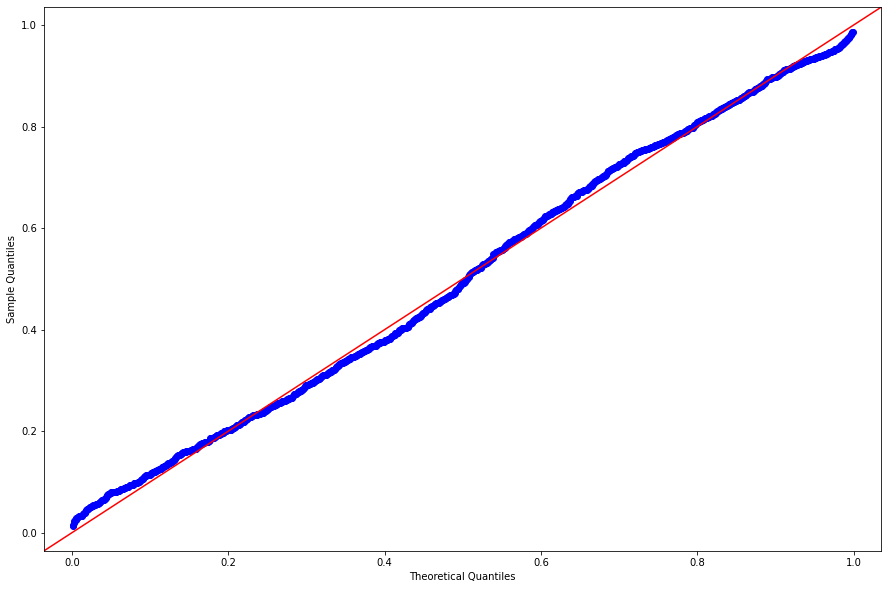

In [210]:
fig = sm.graphics.qqplot(np.array(values), dist=stats.uniform, line="45")

This time the KS test tells us that we can't reject the null hypothesis that the transformed values come from a uniform distribution. However, the QQ plot looks a bit more swirly than the previous one.

# Model Volatility versus Realized Volatility

The model basically finds the value of volatility that fits the return data we give it. It's a type of hierarchical model where volatility is a latent quantity. We cannot directly observe the volatility of a return series in the real world, we can only imply it. In the literature, there is a great deal about how to estimate that latent volatility. I've covered a few of those methods in a [previous post](https://eadains.github.io/OptionallyBayesHugo/posts/vol_estimators/). Let's compare what our model thinks volatility is to a realized volatility estimator. I'm going to be taking the volatility from the second model.

Note I'm taking the proper transformations to ensure both series are in standard deviation form. My volatility data is shorter than my weekly returns data, so I have to truncate some of it.

In [243]:
real_vol = np.sqrt(spx.vol.resample("W-FRI").sum())
model_vol = pd.Series(np.mean(arviz_data.posterior.h.values.reshape(10000, -1), axis=0), index=spx_wk_returns.index)
model_vol = np.sqrt(np.exp(model_vol))

common_index = real_vol.index.intersection(model_vol.index)

real_vol = real_vol.loc[common_index]
model_vol = model_vol.loc[common_index]

<AxesSubplot:>

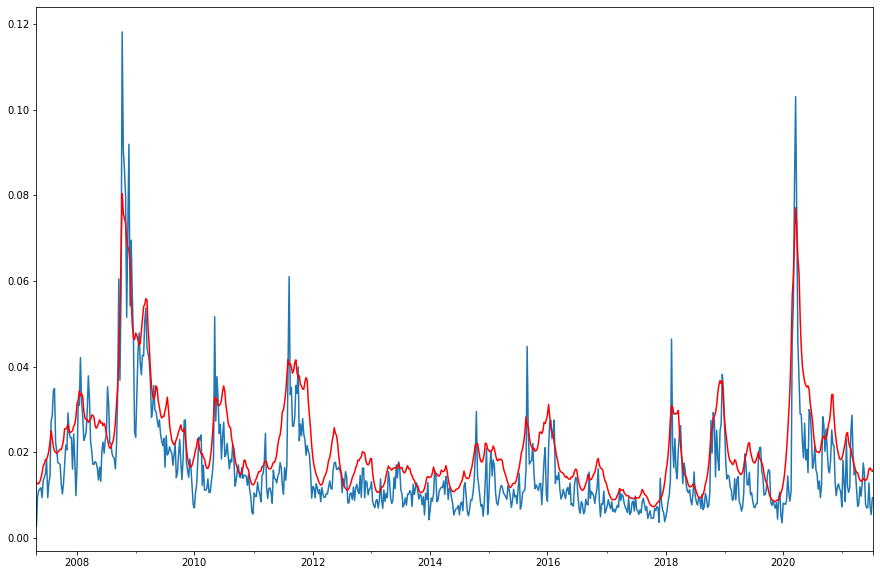

In [245]:
real_vol.plot()
model_vol.plot(color="r")

With the model volatility in red and the realized measure in blue. The model pretty well captures the realized volatility! It's a smoother estimate, which makes sense considering the linear model for it we are using. Cool!

# Conclusion

The model isn't perfect, but then again no model is! The first one fails to capture the negative skew, and while the second one does better, the QQ plot looks less pleasing. This may mean that in doing better capturing skew, it fails to as effectively capture the middle of the distribution.

There are a lot of interesting extensions you could make to this model. The mean process of volatility could include exogenous regressors like VIX levels, or it could include past values of the returns themselves! Next the volatility of volatility, $\sigma$ in the model, could be made to have a stochastic or deterministic process of its own! Essentially, it could be made to vary with time, just like volatility of the returns.